In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from time import time


# This can be useful, install with
# conda install line_profiler
%load_ext line_profiler

# Problem 2


Code for reading and interpolating data from netcdf files is given below

In [2]:
import xarray as xr
from scipy.interpolate import RectBivariateSpline

In [5]:
#################################################
#### Convenience class for reading datafiles ####
#################################################

class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array([(t - d.time[0])/np.timedelta64(1, 's') for t in d.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
    
    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        return np.array([dx, dy])

In [17]:
# Update the file path to where you put the downloaded file
d  = xr.open_dataset('../data/NorKyst-800m_ZDEPTHS_his.an.20240301-05.nc')
# Initialise the interpolator object with the data
f  = Interpolator(dataset = d)

# You can now use the intepolator object as if
# it was a function implmenting f(X, t),
# where X can be a (2, Np) array holding the
# x and y position of Np particles.
# Write your implementation of Heun's method to use this f

Np = 5
X = np.zeros((2, Np))
X[0,:] = np.random.normal(loc = 790000, scale=10000, size = Np)
X[1,:] = np.random.normal(loc = 490000, scale=10000, size = Np)
t = 0.

print(f(X, t))

[[ 0.71466159  0.6049601   0.70420454  0.71996578  0.7087133 ]
 [ 0.03686774 -0.00434476 -0.0113839  -0.0098535   0.27670726]]


## Code for plotting on a map

In [20]:

# Functions for plotting on map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

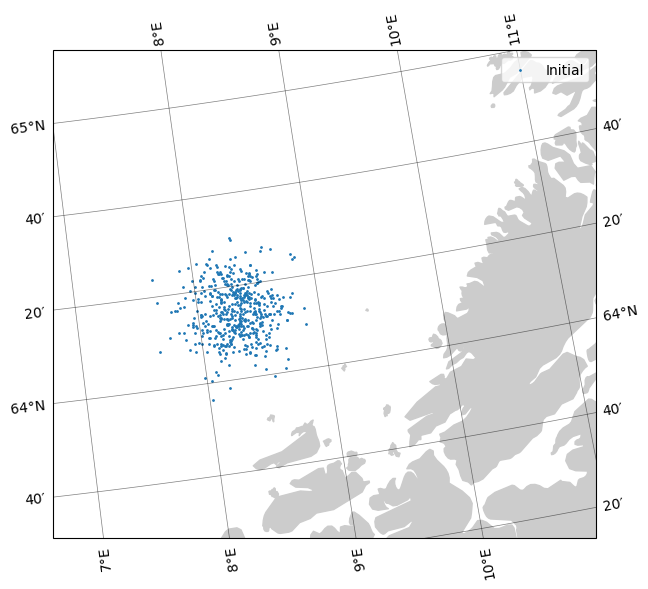

In [21]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))

# Create projection object for converting particle positions
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)

# Create some positions
Np = 500
X = np.zeros((2, Np))
X[0,:] = np.random.normal(loc = 790000, scale=10000, size = Np)
X[1,:] = np.random.normal(loc = 490000, scale=10000, size = Np)


# scatter plot positions, note the extra transform keyword
ax.scatter(X[0,:], X[1,:], s=1, transform=npstere, label='Initial')


# Make outline a bit larger
ax.set_extent((7, 11, 63.5, 65))
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )

ax.legend()
plt.tight_layout()